# 2. Matching by Propensity Score

* **author** = Diego Sapunar-Opazo
* **copyright** = Copyright 2019, Thesis M.Sc. Diego Sapunar - Pontificia Universidad Católica de Chile
* **credits** = Diego Sapunar-Opazo, Ronald Perez, Mar Perez-Sanagustin, Jorge Maldonado-Mahauad
* **maintainer** = Diego Sapunar-Opazo
* **email** = dasapunar@uc.cl
* **status** = Dev

## Part 0: Import Packages

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# stats
from causalinference import CausalModel

## Part 1: Getting the Data

In [5]:
df_sec = pd.read_csv('../../data/clean_data/students_sec.csv')
df_GPA = pd.read_csv('../../data/clean_data/students_GPA.csv')
df_NF = pd.read_csv('../../data/final_data/performance.csv').iloc[:,[0,18]]

In [7]:
df = pd.merge(left=df_sec, right=df_GPA, left_on='num_alumno', right_on='num_alumno')
df = pd.merge(left=df, right=df_NF, left_on='num_alumno', right_on='num_alumno')

In [8]:
df_untreated = df[df['sec'] == 1].copy()
df_treated = df[df['sec'] == 2].copy()

# cleaning memory
del df_sec
del df_GPA
del df_NF
# del df

In [15]:
# replacing treated for 1 or 0
df.replace({1:0, 2:1}, inplace=True)

## Part 2: Groups' distributions

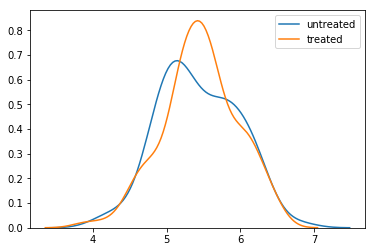

In [36]:
sns.kdeplot(df.loc[lambda x: x.sec == 0].NF, label="untreated")
sns.kdeplot(df.loc[lambda x: x.sec == 1].NF, label="treated")

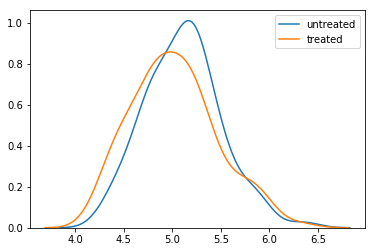

In [10]:
sns.kdeplot(df.loc[lambda x: x.sec == 1].GPA, label="untreated")
sns.kdeplot(df.loc[lambda x: x.sec == 2].GPA, label="treated")

## Part 3: Propensity Score

In [34]:
# OLS estimator
cm = CausalModel(
    Y=df.NF.values, 
    D=df.sec.values, 
    X=df.GPA.values)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.083      0.094      0.887      0.375     -0.100      0.266
           ATC      0.108      0.106      1.026      0.305     -0.099      0.315
           ATT      0.063      0.101      0.618      0.536     -0.136      0.261



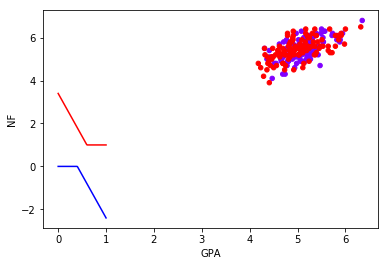

In [31]:
df.plot.scatter(x="GPA", y="NF", c="sec", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

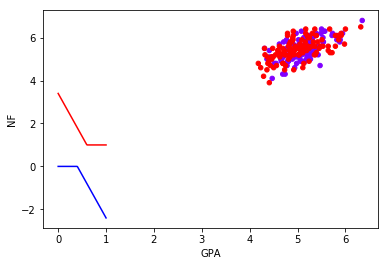

In [26]:
# mask out data ignored by the 
propensity = cm.propensity["fitted"]
cutoff = cm.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
df[mask].plot.scatter(x="GPA", y="NF", c="sec", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.4, -4*(z - 0.4), 0)
y1 =  np.where(z < 0.6,  -4*(z - 0.6), 0) + 1
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")

# filter out data in regions we have trimmed when we calculate the true uplift
filter_ = lambda df: (df.GPA > 0.2) & (df.GPA < 0.7)